# **MONTE CARLO METHODS AND FINITE-SIZE ANALYSIS IN PARAMAGNETIC-FERROMAGNETIC MODELS OF PHASE TRANSITION**

Authors:
* Carlo Divari
* Gloria Isotton
* Maryam Feizi
* Sara Munafò

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

from numba import jit, prange
from scipy.optimize import curve_fit

# **INTRODUCTION**

In [2]:
#introduction

In [3]:
#ising

In [4]:
#metropolis 

In [5]:
#blablabla

# **SIMULATION OF A 2D ISING MODEL**

In [2]:
#Create a nxn lattice with random spin configuration
@jit(nopython=True)
def init_lattice(N):
    '''
    Return a random spin configuration in a 2d square lattice
    '''
    return np.random.choice(np.array([-1,1]),size=(N,N))

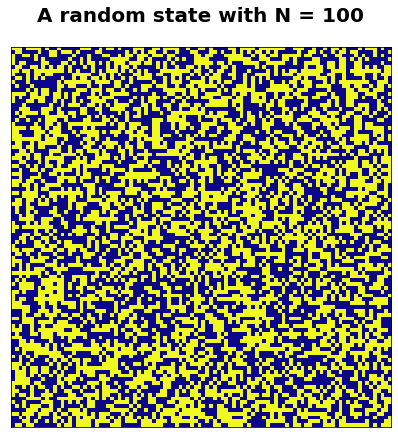

In [3]:
try_state = init_lattice(100)
fig, ax = plt.subplots(figsize=(9,7))
ax.matshow(try_state, cmap = plt.cm.plasma) 
ax.set_xticks([])
ax.set_yticks([])
plt.title('A random state with N = 100', fontsize = 20, fontweight = "bold" )
plt.show()

In [4]:
#Let's define some useful functions
@jit(nopython=True)
def energy(state):
    
    '''define the energy at a given configuration'''
    
    N = state.shape[0]
    energy = 0
  
    for i in range(N):
        for j in range(N):

      # get nearest neighbours states
            nn = state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N]
            energy +=  -state[i,j] * nn
    return energy / 2
    
@jit(nopython=True)    
def magnetization(state):
    
    '''define the magnetization per site'''
    
    Magn = np.sum(state)    
    return Magn

@jit(nopython=True)
def delta(s,a,b):
    L= int(s.shape[0])
    
    '''define delta E between 2 spin configurations'''

    return 2*s[a,b]*(s[a,(b+1)%L]+s[a,(b-1)%L]+s[(a+1)%L,b]+s[(a-1)%L,b])   #consider only nearest neighbours


# **PHASE TRANSITION ANALYSIS**

In [5]:
# Define Monte Carlo function
@jit(nopython=True)
def mc_step(s,temp):
    
    L = int(s.shape[0])
    for i in prange(int(L*L)):
        
        # choose a random spin on the grid
        a, b = np.random.randint(0,L), np.random.randint(0,L)
        
        # compute the delta energy before and after the flip of s(a,b)
        delta_E = delta(s,a,b)  

        # metropolis test and spin-flip
        if delta_E <= 0 or np.random.uniform(0, 1) < np.exp(-delta_E/temp):
            s[a,b]*=-1
    return s

## ---Old code updated---

In [7]:
@jit(nopython=True)
def old_Ising(L,T,time_f,realiz):
    magnetizations=np.zeros(time_f)
    energies=np.zeros(time_f)
        
    for r in range(0,realiz):
        s = np.ones((L,L))
            
        for t in range(0,time_f):
            m = magnetization(s)
            magnetizations[t] = magnetizations[t]+m/realiz
            energies[t] = energies[t]+energy(s)/realiz
            s = mc_step(s, T)
            
        E = np.mean(energies)
        M = np.mean(magnetizations)                
        C = (np.std(energies)**2)/(T**2)
        Chi = (np.std(magnetizations)**2)/(T)
    
    return (E,M,C,Chi)
    
L_val=[4,8,16,50,80,100,500]
nl = int(len(L_val))
time_f = int(1e4)    
realiz = 100    
nt = 80 
E_old,M_old,C_old,Chi_old = np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt)),np.zeros((nl,nt))
Te = np.linspace(1.5,4.,nt)
for il,L in enumerate(L_val):
    print('Simulating N={}'.format(L))
    for it,T in enumerate(Te):
        E,M,C,Chi = old_Ising(L,T,time_f,realiz)
        E_old[il,it] = E
        M_old[il,it] = M
        C_old[il,it] = C
        Chi_old[il,it] = Chi

Simulating N=4


KeyboardInterrupt: 

In [ ]:
def plot_values (E,M,C,Chi,L_val):
    titles = ['Energy','Magnetisation','Specific Heat','Susceptibility']
    #labels = ['e', 'm', 'c', 'chi']
    physical_quantities = [E,np.abs(M),C,Chi]
    plt.figure(figsize = (16,10))
    for i in range(len(physical_quantities)):
        ax = plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        ax.set_title(titles[i], fontsize = 20, fontweight = "bold" )
        ax.grid('--', alpha= 0.7)
        for j in range(nl):
            ax.plot(Te, physical_quantities[i][j] / L_val[j]**2, '.',markersize=9, label='N='+str(L_val[j]), alpha=0.7)
            
            ax.legend()
            
    plt.subplots_adjust(hspace=0.3)

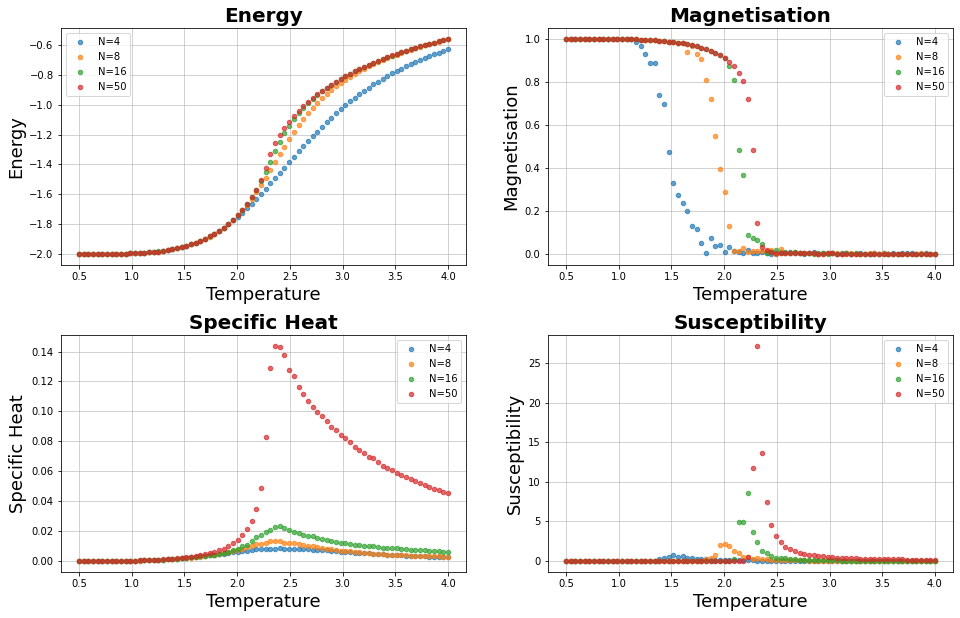

In [45]:
plot_values(E_old,M_old,C_old,Chi_old,L_val)

* Finite size scaling just to confront the results with the ones obrained before *

# **Critical exponent estimation**

## Exponent $\gamma$

In the termodinamic limit $N\rightarrow \infty$, we know that $\chi \sim |T-T_c|^{-\gamma}$. We try to estimate $\gamma$ as N increases. The expected value for 2D Ising is $\gamma=7/4 \sim 1.75$

1st try: fitting only the right part of the plot.
by doing so:
- The fit is good and it fits the points well
- But the values for Tc and gamma are a wrong (even if Tc is sometimes reasonable)

42


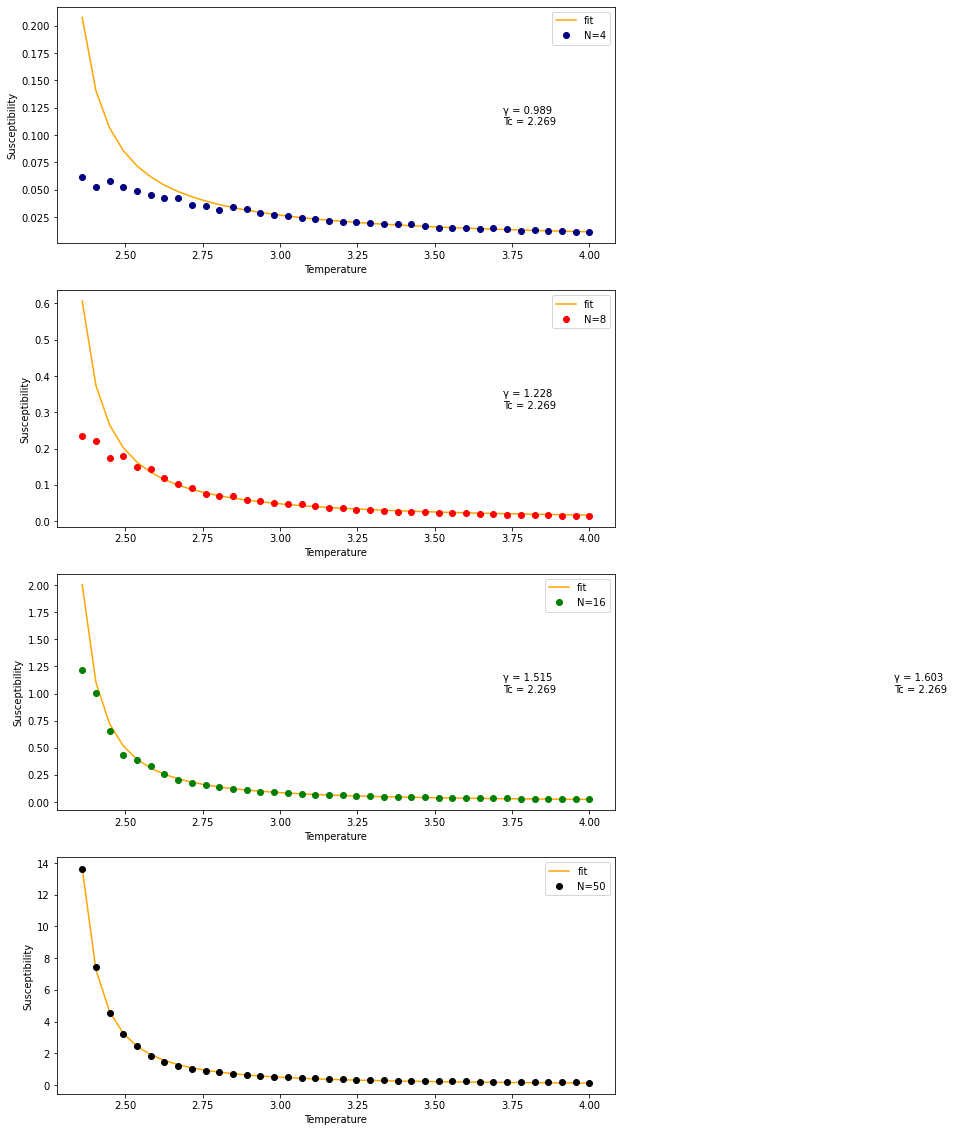

In [46]:
from scipy import optimize

T_c = 2.269     #known value from Onsager
tt = [30, 12, 7,1,1,1]

def powerlaw(T, k=1, gamma=1.75):
    return k*(np.abs(T-T_c))**(-gamma)

ks, gammas, = np.zeros((len(L_val))),np.zeros((len(L_val)))
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 28))
fig.subplots_adjust(hspace = .5, wspace=.01)
axs = axs.ravel()

for i in range(len(L_val)):
    Tmax = np.argmax(Chi_old[i]) +tt[i]#we start from the peak of chi, we study the decreasing exponential
    params, params_covariance = optimize.curve_fit(powerlaw, Te[Tmax:], Chi_old[i][Tmax:]/L_val[i]**2, maxfev=int(1e9))
    ks[i] = params[0]
    gammas[i] = params[1]
    #Tcs[i] = params[2]
    print(Tmax)
    axs[i].plot(Te[Tmax:], powerlaw(Te[Tmax:], ks[i], gammas[i]),'orange', label='fit')
    axs[i].plot(Te[Tmax:], Chi_old[i][Tmax:]/L_val[i]**2, 'o',color="navy", label='N={}'.format(L_val[i]))
    axs[i].text(0.8,0.5,'γ = {}\nTc = {}'.format('%.3f'%(gammas[i]),'%.3f'%T_c), transform=axs[i].transAxes)
    axs[i].set_xlabel('Temperature')
    axs[i].set_ylabel('Susceptibility')
    axs[i].legend()

fig.savefig('full_figure_gamma.png')